In [1]:
from trainer.trainer import CWPTT
import matplotlib.pyplot as plt
trainer = CWPTT(2, "cuda")
trainer.agent.load("../model/planTrack.ptd")

Output()

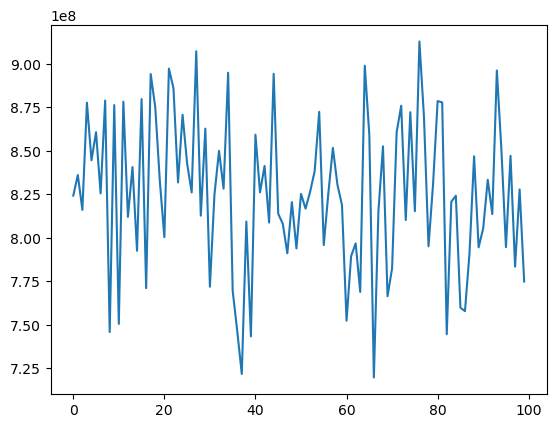

In [2]:
ll = trainer.trainTracker(1200,)
trainer.agent.save("../model/planTrack.ptd")
plt.close("all")
plt.plot(ll)
plt.show()

Output()

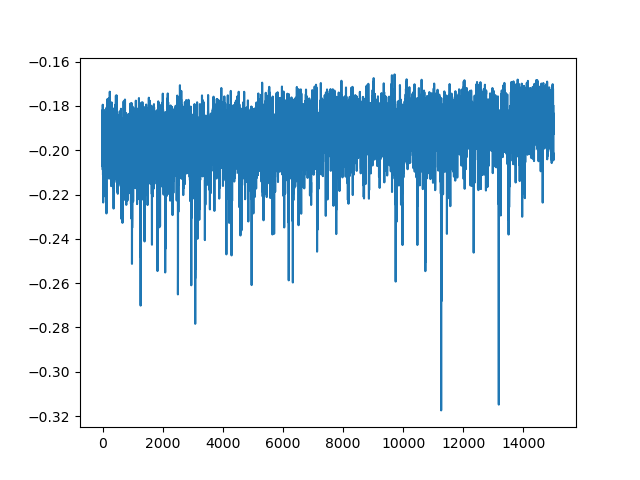

In [4]:
al, cl, tr = trainer.trainPlaner(episode=1000, epoch=15)
trainer.agent.save("../model/planTrack.ptd")
plt.close("all")
plt.plot(tr)
plt.show()

In [8]:
horizon = 3600
d, stage = trainer.test(horizon)

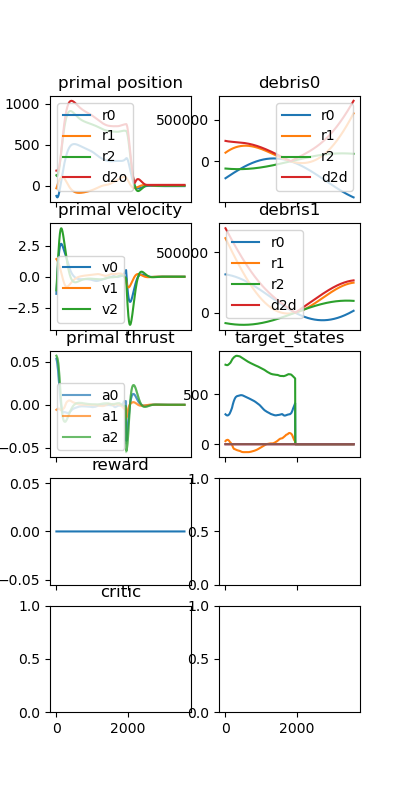

In [9]:
from plotting.analyze import *
%matplotlib widget
plt.close('all')
# n_debris = 0
n_debris = trainer.mainProp.n_debris
fig, _ = historyFile(d, agent=None, stage=stage, n_debris=n_debris, items=("target_states",))